In [58]:
import numpy as np
import pandas as pd
import instrumentum

import lightgbm as ltb
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split

from instrumentum.model_tuning.wrapper_optuna import OptunaSearchCV
from instrumentum.model_tuning._optuna_dispatchers import optuna_param_disp

RANDOM_SEED = 42

In [59]:
# Specify data paths
dataset = 'out/gestures.csv'
model_save_path = 'models/classifier.joblib'

# Load Dataset

In [60]:
data = pd.read_csv(dataset, header=None) 

y = data.iloc[:, 0]
X = data.iloc[: , 1:]

y.value_counts()

random         1874
hand_closed     673
two_up          648
hang_in         623
hand_open       581
victory         530
call            525
one_up          416
machedici       414
ok              409
Name: 0, dtype: int64

In [61]:
classes = y.unique()
classes = {classes[i]: i for i in range(len(classes))}

y = y.map(classes)

X = X.to_numpy().astype(np.float32)
y = y.to_numpy().astype(np.float32)

classes

{'ok': 0,
 'victory': 1,
 'call': 2,
 'hang_in': 3,
 'one_up': 4,
 'two_up': 5,
 'hand_closed': 6,
 'hand_open': 7,
 'machedici': 8,
 'random': 9}

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.99, random_state=RANDOM_SEED)
# # y_train = y_train.reshape(len(y_train),1)
# # y_test = y_test.reshape(len(y_test),1)
# classes = len(np.unique(y))

In [56]:
import optuna

def _lgbmclassifier_default(trial: optuna.trial.Trial):
    params = {
        # "verbosity": -1,
        "boosting_type": trial.suggest_categorical(
            "boosting_type", ["gbdt", "dart", "goss"]
        ),
        "verbose": -1,
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_leaves": trial.suggest_int("num_leaves", 5, 500, step=5),
        "max_depth": trial.suggest_int("max_depth", 1, 15),
        "learning_rate": trial.suggest_float(
            "learning_rate", 1e-5, 1.0, log=True
        ),
        "colsample_bytree": trial.suggest_uniform(
            "colsample_bytree", 0.0, 1.0
        ),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 30),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 30),
        "min_split_gain": trial.suggest_float("min_split_gain", 0, 15),
    }

    return params

In [66]:
estimator = ltb.LGBMClassifier()

# search_function = optuna_param_disp[estimator.__class__.__name__]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

os = OptunaSearchCV(
    estimator=estimator,
    scoring="roc_auc_ovo",
    cv=cv,
    search_space=_lgbmclassifier_default,
    n_iter=5,
)
os.fit(X_train, y_train)

22-07-30 01:27 | INFO | Trials: 1, Best Score: 0.9792847207354292, Score 0.9792847207354292
22-07-30 01:27 | INFO | Trials: 2, Best Score: 0.9983631423121565, Score 0.9983631423121565
22-07-30 01:28 | INFO | Trials: 3, Best Score: 0.9983631423121565, Score 0.9976858213725694
22-07-30 01:28 | INFO | Trials: 4, Best Score: 0.9987938119603038, Score 0.9987938119603038
22-07-30 01:28 | INFO | Trials: 5, Best Score: 0.9987938119603038, Score 0.9967759183653534


OptunaSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=None),
               estimator=LGBMClassifier(), n_iter=5, scoring='roc_auc_ovo',
               search_space=<function _lgbmclassifier_default at 0x29b75c670>,
               verbose=0)

In [67]:
predict_result = os.best_estimator_.predict_proba(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[3.91493295e-04 1.68457499e-04 2.71470179e-04 7.86689512e-05
 1.34053602e-04 2.84267395e-04 4.19911538e-03 1.73526037e-03
 1.89259119e-03 9.90844622e-01]
9


In [68]:
Y_pred = os.best_estimator_.predict_proba(X_test)
y_pred = np.argmax(Y_pred, axis=1)

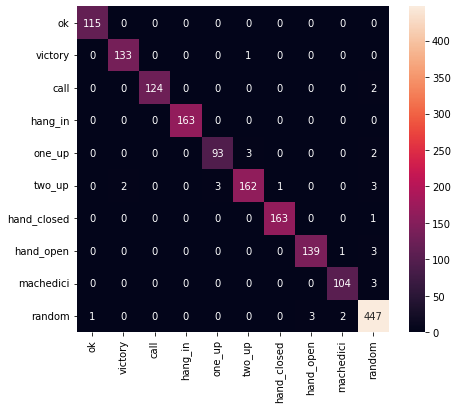

Classification Report
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       115
         1.0       0.99      0.99      0.99       134
         2.0       1.00      0.98      0.99       126
         3.0       1.00      1.00      1.00       163
         4.0       0.97      0.95      0.96        98
         5.0       0.98      0.95      0.96       171
         6.0       0.99      0.99      0.99       164
         7.0       0.98      0.97      0.98       143
         8.0       0.97      0.97      0.97       107
         9.0       0.97      0.99      0.98       453

    accuracy                           0.98      1674
   macro avg       0.98      0.98      0.98      1674
weighted avg       0.98      0.98      0.98      1674



In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, dict_keys=None, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    if dict_keys:
        labels = [dict_keys[x] for x in labels]

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))


print_confusion_matrix(y_test, y_pred, {v: k for k, v in classes.items()})

## Save Model

In [69]:
from joblib import dump, load

dump(os.best_estimator_, model_save_path) 

['models/classifier.joblib']